In [1]:
import math
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import torch
import urllib.request

from collections import Counter
from fasttext import train_unsupervised
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_ as clip_grad_norm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

In [2]:
## Download the data
if not os.path.isdir("wiki"):
    url = "https://yangfengji.net/uva-nlp-course/data/wiki.zip"
    filename, headers = urllib.request.urlretrieve(url, filename="wiki.zip")
    !unzip wiki.zip
    print("Done")
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [3]:
## Random seeds, to make the results reproducible
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(torch.randn(5))

tensor([ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519])


# Common functions

In [4]:
def train(model, trn_dataloader, optimizer, criterion, device=torch.device('cpu')):
    total_batch = 0

    for batch, target in trn_dataloader:
        total_batch += 1

        model.train()
        batch = batch.to(device)
        target = target.to(device)
        target = target.view(-1)

        optimizer.zero_grad()
        output = model(batch)
        output = output.view(-1, output.shape[2])

        loss = criterion(output, target)
        loss.backward()
        clip_grad_norm(model.parameters(), 1.0)
        optimizer.step()
        trn_loss = loss.data.item()

        if total_batch % 500 == 0:
            print(f"[{total_batch:}]:\ttrn_loss = {trn_loss:.4f}")
    
    return model

In [5]:
def eval(data_iter, model, criterion, pad_idx, device=torch.device('cpu')):
    model.eval()
    total_loss, n_batch = 0, 0
    
    total_tokens = 0
    total_logs = 0
    sum_criterion = nn.NLLLoss(
        ignore_index=pad_idx,
        reduction='sum'
    )

    for batch, target in data_iter:
        batch = batch.to(device)
        target = target.to(device)
        target = target.view(-1)

        output = model(batch)
        output = output.view(-1, output.shape[2])

        u_vals, counts = torch.unique(batch, return_counts=True)
        aux = counts[u_vals == pad_idx]
        n_pad_tokens = aux.item() if len(aux) > 0 else 0
        total_tokens += batch.shape[0] * batch.shape[1] - n_pad_tokens
        log_prob = sum_criterion(output, target)
        total_logs += log_prob.data.item()

        n_batch += 1
        loss = criterion(output, target)
        total_loss += loss.data.item()

    avg_loss = total_loss/n_batch
    avg_log_prob = total_logs/total_tokens
    return avg_loss, avg_log_prob

# Load data
I did not used the same functions as Aidan used in the template because when he released it, I had already implemented my functions. I used the `basic_english` tokenizer and `vocabulary` from `torchtext` library. And while building the vocabulary, I set the `min_freq` parameter to drop words that appear less than 10 times in the corpus.

In [6]:
class Wikitext2(Dataset):
    def __init__(self, split):
        if split == 'trn':
            data = pd.read_csv('./wiki/trn-wiki.txt', delimiter='\n', names=['sentences'])
        elif split == 'dev':
            data = pd.read_csv('./wiki/dev-wiki.txt', delimiter='\n', names=['sentences'])
        else:
            raise ValueError("Unrecognized dataset type. Try 'trn' or 'dev'")
        
        self.sentences = list(data['sentences'])
        self.n_sentences = len(self.sentences)

    def __getitem__(self, index):
        return self.sentences[index]

    def __len__(self):
        return self.n_sentences

In [7]:
dataset_trn = Wikitext2('trn')
dataset_dev = Wikitext2('dev')

## Group sentences with same length

In [8]:
class BucketIterator():
    def __init__(self, dataset, batch_size=8):
        self.dataset = dataset
        self.dataset_len = len(dataset)
        self.batch_size = batch_size

        indices = [(i, len(tokenizer(s))) for i, s in enumerate(dataset)]
        pooled_indices = []
        for i in range(0, len(indices), batch_size * 100):
            pooled_indices.extend(sorted(indices[i:i + batch_size * 100], key=lambda x: x[1]))

        self.pooled_indices = [x[0] for x in pooled_indices]
        self.pointer = 0

    def __iter__(self):
        self.pointer = 0
        return self

    def __next__(self):
        if self.pointer > self.dataset_len:
            self.pointer = 0
            raise StopIteration
        else:
            start = self.pointer
            end = self.pointer + self.batch_size
            self.pointer += self.batch_size
        
            return self.pooled_indices[start:end]

## Create dataloader based on a tokenizer

In [9]:
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for s in dataset_trn:
    counter.update(tokenizer(s))

vocabulary = Vocab(counter, min_freq=10, specials=('<unk>', '<num>', '<start>', '<stop>', '<pad>'))
pad_idx = vocabulary.stoi['<pad>']

print("The length of the new vocab is", len(vocabulary))
print("The <unk> token is: ", vocabulary['<unk>'])
print("The <num> token is: ", vocabulary['<num>'])
print("The <start> token is: ", vocabulary['<start>'])
print("The <stop> token is: ", vocabulary['<stop>'])
print("The <pad> token is: ", vocabulary['<pad>'])

The length of the new vocab is 12353
The <unk> token is:  0
The <num> token is:  1
The <start> token is:  2
The <stop> token is:  3
The <pad> token is:  4


In [10]:
text_transform_input = lambda x: [vocabulary[token] for token in tokenizer(x) if token != '<stop>']
text_transform_target = lambda x: [vocabulary[token] for token in tokenizer(x) if token != '<start>']

def collate_batch(batch):
    input_sentences_list = []
    target_sentences_list = []
    for sentence in batch:
        i_tensor = torch.tensor(text_transform_input(sentence))
        input_sentences_list.append(i_tensor)
        t_tensor = torch.tensor(text_transform_target(sentence))
        target_sentences_list.append(t_tensor)
    
    return pad_sequence(input_sentences_list, padding_value=pad_idx), pad_sequence(target_sentences_list, padding_value=pad_idx)

trn_dataloader = DataLoader(dataset_trn, batch_sampler=BucketIterator(dataset_trn,8), collate_fn=collate_batch)
dev_dataloader = DataLoader(dataset_dev, batch_sampler=BucketIterator(dataset_dev,8), collate_fn=collate_batch)

# SimpleRNN Model Class

In [11]:
class SimpleRNN(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 pretrained_embedding=torch.tensor([]), 
                 drop_rate=0.0, 
                 n_inputs=32, 
                 n_hidden_units=32, 
                 n_layers=1, 
                 pad_idx=4):
        
        super(SimpleRNN, self).__init__()

        # ---------------------------------
        # Configuration
        self.vocab_size = vocab_size
        self.n_inputs = n_inputs
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.pad_idx = pad_idx

        # ---------------------------------
        # Network parameters
        self.dropout = nn.Dropout(drop_rate)
        if len(pretrained_embedding) != 0:
            self.embedding = nn.Embedding.from_pretrained(
                embeddings=pretrained_embedding,
                freeze=False,
                padding_idx=pad_idx
            )
        else:
            self.embedding = nn.Embedding(
                num_embeddings=self.vocab_size, 
                embedding_dim=self.n_inputs, 
                padding_idx=self.pad_idx
            )
        self.lstm = nn.LSTM(
            input_size=self.n_inputs,
            hidden_size=self.n_hidden_units,
            num_layers=self.n_layers
        )
        self.fc = nn.Linear(
            in_features=self.n_hidden_units,
            out_features=self.vocab_size
        )
        self.logSoftmax = nn.LogSoftmax(dim=2)

    def forward(self, batch):
        x = self.embedding(batch)
        x = self.dropout(x)
        output, hidden = self.lstm(x)
        logits = self.fc(output)
        logprob = self.logSoftmax(logits)
        
        return logprob

Note that the last layer of my SimpleRNN model calculates the log probabilities of the logits. Therefore for the entire homework I used the `NLLLoss` insted of `CrossEntropy` as the loss function.

# Simple RNN LM
I did a lot of experiments with the "simple" RNN to hypertune some of the paramters. I started using SGD as optimizer as it was indicated in the hw. But then I tried Adam with a learning rate of 0.01 which performed much better than SGD, at least for the first few epochs. So I used `Adam` for the rest of the homework. Another thing that I used was `dropout` at a 0.5 rate.

In [13]:
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

model = SimpleRNN(
    vocab_size=len(vocabulary),
    drop_rate=0.5,
    n_inputs=32,
    n_hidden_units=32,
    n_layers=1,
    pad_idx=pad_idx
).to(device)
optimizer = optim.Adam(
    params=model.parameters(),
    lr=0.01,
    weight_decay=0
)
criterion = nn.NLLLoss(ignore_index=pad_idx)
epochs = 5

In [14]:
for e in range(epochs):
    print('\n' if e != 0 else '')
    print("Epoch {}\n".format(e))
    
    model = train(
        model=model,
        trn_dataloader=trn_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    trn_loss, avg_trn_log_prob = eval(
        data_iter=trn_dataloader,
        model=model,
        criterion=criterion,
        pad_idx=pad_idx,
        device=device
    )
    val_loss, avg_val_log_prob = eval(
        data_iter=dev_dataloader,
        model=model,
        criterion=criterion,
        pad_idx=pad_idx,
        device=device
    )
    print(f"\nTraining Loss: {trn_loss}")
    print(f"Perplexity Training set: {math.exp(avg_trn_log_prob)}")
    print(f"Validation Loss: {val_loss}")
    print(f"Perplexity Validation set: {math.exp(avg_val_log_prob)}")


Epoch 0

[500]:	trn_loss = 6.0752
[1000]:	trn_loss = 5.9120
[1500]:	trn_loss = 5.8719
[2000]:	trn_loss = 5.8389

Training Loss: 5.7389580576729395
Perplexity Training set: 346.237966110283
Validation Loss: 5.681792698897325
Perplexity Validation set: 299.6064062628341


Epoch 1

[500]:	trn_loss = 5.7587
[1000]:	trn_loss = 5.6833
[1500]:	trn_loss = 5.7086
[2000]:	trn_loss = 5.7241

Training Loss: 5.557142457875141
Perplexity Training set: 300.0092807710143
Validation Loss: 5.592582291854924
Perplexity Validation set: 274.035370807643


Epoch 2

[500]:	trn_loss = 5.7095
[1000]:	trn_loss = 5.6176
[1500]:	trn_loss = 5.6330
[2000]:	trn_loss = 5.6717

Training Loss: 5.460428419851768
Perplexity Training set: 277.531147420772
Validation Loss: 5.559085294797823
Perplexity Validation set: 263.9138566207442


Epoch 3

[500]:	trn_loss = 5.6750
[1000]:	trn_loss = 5.5341
[1500]:	trn_loss = 5.6224
[2000]:	trn_loss = 5.6664

Training Loss: 5.40186262163323
Perplexity Training set: 265.41090477387627

# Perplexity
I did not created a specific function for calculating the perplexity, however I calculate the `-avg` inside the `eval()` since it iterates through the entire corpus (either the training set or the validations set can be passed as a parameter to this function). After getting the -avg, I exponentiate it using `math.exp()`

In [15]:
trn_loss, avg_trn_log_prob = eval(
    data_iter=trn_dataloader,
    model=model,
    criterion=criterion,
    pad_idx=pad_idx,
    device=device
)
val_loss, avg_val_log_prob = eval(
    data_iter=dev_dataloader,
    model=model,
    criterion=criterion,
    pad_idx=pad_idx,
    device=device
)
print(f"Training Loss: {trn_loss}")
print(f"Perplexity Training set: {math.exp(avg_trn_log_prob)}")
print(f"Validation Loss: {val_loss}")
print(f"Perplexity Validation set: {math.exp(avg_val_log_prob)}")

Training Loss: 5.358815792970071
Perplexity Training set: 256.8794429860463
Validation Loss: 5.545172678959834
Perplexity Validation set: 258.7078753314648


Note: The values above are from the SimpleRNN trained in the previous section

# Stacked LSTM
To compare the multi-layer LSTM, I instantiated the class `SimpleRNN` with different values for the `n_layers` parameter (1 $\leq$ n_layers $\leq$ 3). In addition, I used Adam optimizer with a learning rate of 0.01, which make the models converge faster than SGD for 5 epochs.

## 2 Layers LSTM

In [18]:
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')
model = SimpleRNN(
    vocab_size=len(vocabulary),
    drop_rate=0.5,
    n_inputs=32,
    n_hidden_units=32,
    n_layers=2,
    pad_idx=pad_idx
).to(device)
optimizer = optim.Adam(
    params=model.parameters(),
    lr=0.01,
    weight_decay=0
)
criterion = nn.NLLLoss(ignore_index=pad_idx)
epochs = 5

In [19]:
for e in range(epochs):
    print('\n' if e != 0 else '')
    print("Epoch {}\n".format(e))
    
    model = train(
        model=model,
        trn_dataloader=trn_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    
    trn_loss, avg_trn_log_prob = eval(
        data_iter=trn_dataloader,
        model=model,
        criterion=criterion,
        pad_idx=pad_idx,
        device=device
    )
    val_loss, avg_val_log_prob = eval(
        data_iter=dev_dataloader,
        model=model,
        criterion=criterion,
        pad_idx=pad_idx,
        device=device
    )
    print(f"\nTraining Loss: {trn_loss}")
    print(f"Perplexity Training set: {math.exp(avg_trn_log_prob)}")
    print(f"Validation Loss: {val_loss}")
    print(f"Perplexity Validation set: {math.exp(avg_val_log_prob)}")


Epoch 0

[500]:	trn_loss = 6.2164
[1000]:	trn_loss = 6.0394
[1500]:	trn_loss = 6.0068
[2000]:	trn_loss = 5.9189

Training Loss: 5.8881713428366975
Perplexity Training set: 400.44018971682846
Validation Loss: 5.7991206491148315
Perplexity Validation set: 339.2702223597262


Epoch 1

[500]:	trn_loss = 5.8610
[1000]:	trn_loss = 5.7713
[1500]:	trn_loss = 5.7853
[2000]:	trn_loss = 5.7825

Training Loss: 5.700723738007774
Perplexity Training set: 342.72554362517434
Validation Loss: 5.690748970229905
Perplexity Validation set: 302.7153157384653


Epoch 2

[500]:	trn_loss = 5.7455
[1000]:	trn_loss = 5.6496
[1500]:	trn_loss = 5.6602
[2000]:	trn_loss = 5.7088

Training Loss: 5.599702034235544
Perplexity Training set: 314.5391893519818
Validation Loss: 5.638436428912274
Perplexity Validation set: 285.3690524821787


Epoch 3

[500]:	trn_loss = 5.6938
[1000]:	trn_loss = 5.5833
[1500]:	trn_loss = 5.6210
[2000]:	trn_loss = 5.6771

Training Loss: 5.543282895099058
Perplexity Training set: 299.3984079

## 3 Layers LSTM

In [20]:
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

model = SimpleRNN(
    vocab_size=len(vocabulary),
    drop_rate=0.5,
    n_inputs=32,
    n_hidden_units=32,
    n_layers=3,
    pad_idx=pad_idx
).to(device)
optimizer = optim.Adam(
    params=model.parameters(),
    lr=0.01,
    weight_decay=0
)
criterion = nn.NLLLoss(ignore_index=pad_idx)
epochs = 5

In [21]:
for e in range(epochs):
    print('\n' if e != 0 else '')
    print("Epoch {}\n".format(e))
    
    model = train(
        model=model,
        trn_dataloader=trn_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    
    trn_loss, avg_trn_log_prob = eval(
        data_iter=trn_dataloader,
        model=model,
        criterion=criterion,
        pad_idx=pad_idx,
        device=device
    )
    val_loss, avg_val_log_prob = eval(
        data_iter=dev_dataloader,
        model=model,
        criterion=criterion,
        pad_idx=pad_idx,
        device=device
    )
    print(f"\nTraining Loss: {trn_loss}")
    print(f"Perplexity Training set: {math.exp(avg_trn_log_prob)}")
    print(f"Validation Loss: {val_loss}")
    print(f"Perplexity Validation set: {math.exp(avg_val_log_prob)}")


Epoch 0

[500]:	trn_loss = 6.3476
[1000]:	trn_loss = 6.1846
[1500]:	trn_loss = 6.1530
[2000]:	trn_loss = 6.0556

Training Loss: 6.041928723841431
Perplexity Training set: 457.0513075550531
Validation Loss: 5.926926024548419
Perplexity Validation set: 379.7641788672956


Epoch 1

[500]:	trn_loss = 5.9259
[1000]:	trn_loss = 5.8476
[1500]:	trn_loss = 5.8897
[2000]:	trn_loss = 5.8596

Training Loss: 5.840389257683026
Perplexity Training set: 388.7438634056239
Validation Loss: 5.788849937967408
Perplexity Validation set: 332.9066457088796


Epoch 2

[500]:	trn_loss = 5.7858
[1000]:	trn_loss = 5.7496
[1500]:	trn_loss = 5.7893
[2000]:	trn_loss = 5.7609

Training Loss: 5.778432687268442
Perplexity Training set: 370.7899167808169
Validation Loss: 5.765017955334155
Perplexity Validation set: 321.04123068954834


Epoch 3

[500]:	trn_loss = 5.7219
[1000]:	trn_loss = 5.6665
[1500]:	trn_loss = 5.7302
[2000]:	trn_loss = 5.7109

Training Loss: 5.69202723991898
Perplexity Training set: 346.11034636650

## Results
After trying 1,2 and 3 stacked LSTM layers, the model which got the lowest validation perplexity from the three was the one with 1 layer.

- Best model was achieved using `n` = 1
- Perplexity on training data: `256.87`
- Perplexity on validation data: `258.70`

# Model Size
To compare different models sizes, I built a nested for loop that iterates over the `input dimensions` and the `hidden dimensions`, and instantiated the class `SimpleRNN` with different values for the `n_inputs` and `n_hidden_units` parameters respectively. I also used Adam optimizer with a learning rate of 0.01 because, as mentioned before, it outperforms SGD for a 5 epochs. The main reason for using only 5 epochs is that I wanted to get a sense of how these two hyperparameters impact the performance of the model, and training them with more epochs would have required much more time.

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
data = pd.DataFrame(
    columns=['n_inputs', \
             'n_hidden_units', \
             'epoch', \
             'trn_loss', \
             'val_loss', \
             'trn_perplexity', \
             'val_perplexity']
)

for n_inputs in [32,64,128,256]:
    for n_hidden_units in [32,64,128,256]:
        print('-'*40)
        print(f"n_inputs: {n_inputs} \t n_hidden_units: {n_hidden_units}")
        print('-'*40)
        model = SimpleRNN(
            vocab_size=len(vocabulary),
            drop_rate=0.5,
            n_inputs=n_inputs,
            n_hidden_units=n_hidden_units,
            n_layers=1,
            pad_idx=pad_idx
        ).to(device)
        optimizer = optim.Adam(
            params=model.parameters(),
            lr=0.01,
            weight_decay=0
        )
        criterion = nn.NLLLoss(ignore_index=pad_idx)
        epochs = 5
        
        for e in range(epochs):
            print('\n' if e != 0 else '')
            print(f"Epoch {e}\n")
            model = train(
                model=model,
                trn_dataloader=trn_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                device=device
            )
            trn_loss, avg_trn_log_prob = eval(
                data_iter=trn_dataloader,
                model=model,
                criterion=criterion,
                pad_idx=pad_idx,
                device=device
            )
            val_loss, avg_val_log_prob = eval(
                data_iter=dev_dataloader,
                model=model,
                criterion=criterion,
                pad_idx=pad_idx,
                device=device
            )
            trn_perplexity = math.exp(avg_trn_log_prob)
            val_perplexity = math.exp(avg_val_log_prob)
            print(f"\nTraining Loss: {trn_loss}")
            print(f"Perplexity Training set: {trn_perplexity}")
            print(f"Validation Loss: {val_loss}")
            print(f"Perplexity Validation set: {val_perplexity}")

            if e+1 == epochs:
                print('\n')

            data.loc[len(data)] = [n_inputs,n_hidden_units,e,trn_loss,val_loss,trn_perplexity,val_perplexity]
            data.to_csv('./data-with-dropout.csv')

----------------------------------------
n_inputs: 32 	 n_hidden_units: 32
----------------------------------------

Epoch 0

[500]:	trn_loss = 6.0738
[1000]:	trn_loss = 5.9070
[1500]:	trn_loss = 5.8770
[2000]:	trn_loss = 5.8555

Training Loss: 5.726507604312245
Perplexity Training set: 343.00048475282966
Validation Loss: 5.670600383312671
Perplexity Validation set: 297.28670729048184


Epoch 1

[500]:	trn_loss = 5.7837
[1000]:	trn_loss = 5.6975
[1500]:	trn_loss = 5.6873
[2000]:	trn_loss = 5.7307

Training Loss: 5.5561309211618
Perplexity Training set: 300.08341864670996
Validation Loss: 5.592244633348473
Perplexity Validation set: 273.81205714182744


Epoch 2

[500]:	trn_loss = 5.6887
[1000]:	trn_loss = 5.6025
[1500]:	trn_loss = 5.6105
[2000]:	trn_loss = 5.6763

Training Loss: 5.46590588500125
Perplexity Training set: 278.48900811686116
Validation Loss: 5.565244468259605
Perplexity Validation set: 264.48308846949885


Epoch 3

[500]:	trn_loss = 5.6472
[1000]:	trn_loss = 5.5803
[1500]:

[500]:	trn_loss = 5.5764
[1000]:	trn_loss = 5.4779
[1500]:	trn_loss = 5.5097
[2000]:	trn_loss = 5.5838

Training Loss: 5.281753675812741
Perplexity Training set: 237.76675342936582
Validation Loss: 5.5283788416808815
Perplexity Validation set: 254.2148929638145


Epoch 4

[500]:	trn_loss = 5.5688
[1000]:	trn_loss = 5.4646
[1500]:	trn_loss = 5.4680
[2000]:	trn_loss = 5.5739

Training Loss: 5.22531301079144
Perplexity Training set: 227.38967644192616
Validation Loss: 5.5388769855746975
Perplexity Validation set: 254.4903391177325


----------------------------------------
n_inputs: 64 	 n_hidden_units: 128
----------------------------------------

Epoch 0

[500]:	trn_loss = 5.9555
[1000]:	trn_loss = 5.8039
[1500]:	trn_loss = 5.8010
[2000]:	trn_loss = 5.8046

Training Loss: 5.58367550313337
Perplexity Training set: 298.2786095859542
Validation Loss: 5.592321864454261
Perplexity Validation set: 271.68882619025766


Epoch 1

[500]:	trn_loss = 5.6526
[1000]:	trn_loss = 5.5077
[1500]:	trn_los

[500]:	trn_loss = 5.6532
[1000]:	trn_loss = 5.5493
[1500]:	trn_loss = 5.5421
[2000]:	trn_loss = 5.6503

Training Loss: 5.352245485701159
Perplexity Training set: 246.04976627830203
Validation Loss: 5.51985519169729
Perplexity Validation set: 253.389133772554


Epoch 2

[500]:	trn_loss = 5.5632
[1000]:	trn_loss = 5.4287
[1500]:	trn_loss = 5.4414
[2000]:	trn_loss = 5.5570

Training Loss: 5.192715435636342
Perplexity Training set: 219.42824131367203
Validation Loss: 5.491609018086355
Perplexity Validation set: 246.3752686958235


Epoch 3

[500]:	trn_loss = 5.5038
[1000]:	trn_loss = 5.3576
[1500]:	trn_loss = 5.3821
[2000]:	trn_loss = 5.5098

Training Loss: 5.112046490280394
Perplexity Training set: 202.69877731512554
Validation Loss: 5.514800878830286
Perplexity Validation set: 247.1441758832687


Epoch 4

[500]:	trn_loss = 5.4450
[1000]:	trn_loss = 5.3227
[1500]:	trn_loss = 5.3718
[2000]:	trn_loss = 5.5364

Training Loss: 5.006252164938456
Perplexity Training set: 187.77818834387966
Valid

In [12]:
### Load data
data = pd.read_csv('./data-with-dropout.csv', index_col=0)

In [13]:
data.insert(0, "models", data.apply(lambda row: str(int(row.n_inputs)) + ' - ' + str(int(row.n_hidden_units)), axis=1))
data.head()

,models,n_inputs,n_hidden_units,epoch,trn_loss,val_loss,trn_perplexity,val_perplexity
0,32 - 32,32.0,32.0,0.0,5.726508,5.670600,343.000485,297.286707
1,32 - 32,32.0,32.0,1.0,5.556131,5.592245,300.083419,273.812057
2,32 - 32,32.0,32.0,2.0,5.465906,5.565244,278.489008,264.483088
3,32 - 32,32.0,32.0,3.0,5.406817,5.560198,266.566509,261.108855
4,32 - 32,32.0,32.0,4.0,5.365168,5.560459,258.383199,259.882937


In [14]:
df_long1=pd.melt(data,id_vars=['models'],value_vars=['trn_loss','val_loss'],var_name='Loss')

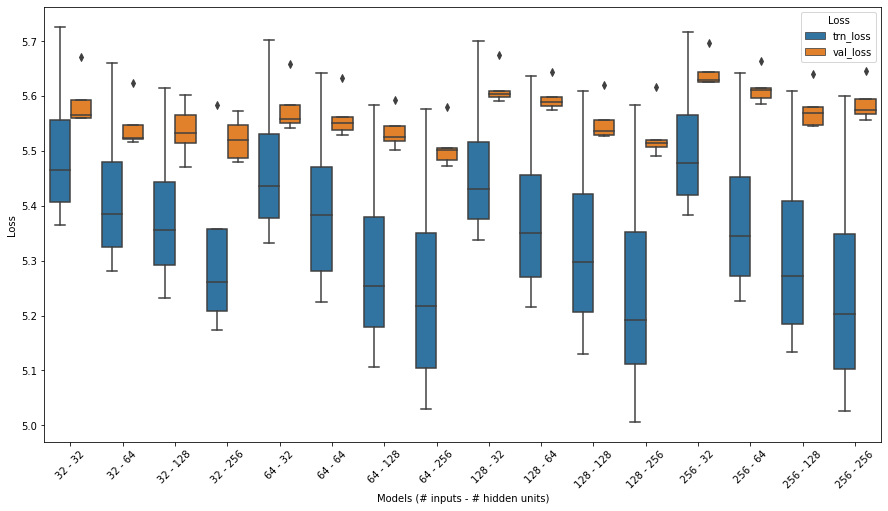

In [15]:
g = sns.boxplot(x='models',y='value',data=df_long1,hue='Loss')
g.set_xticklabels(df_long1.models.unique(),rotation=45);
g.set_ylabel('Loss');
g.set_xlabel('Models (# inputs - # hidden units)');
g.figure.set_figwidth(15)
g.figure.set_figheight(8)

In [16]:
df_long2=pd.melt(data,id_vars=['models'],value_vars=['trn_perplexity','val_perplexity'],var_name='Perplexity')

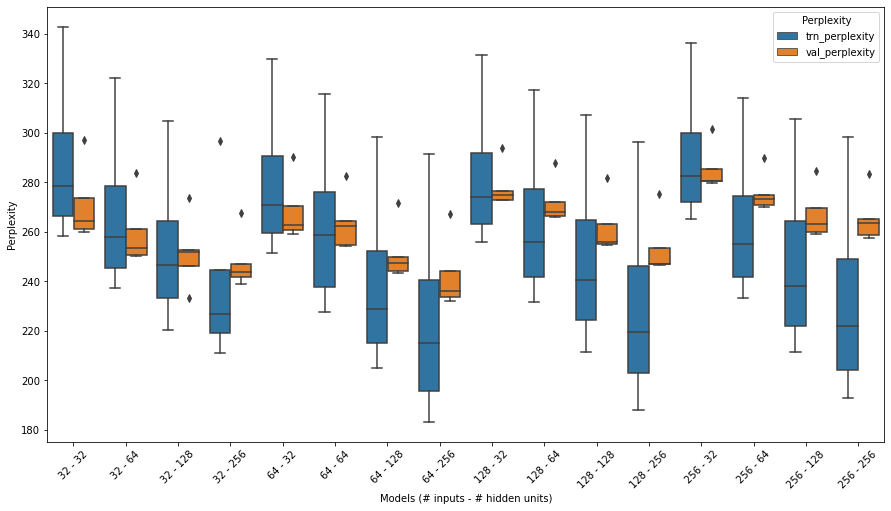

In [17]:
g = sns.boxplot(x='models',y='value',data=df_long2,hue='Perplexity')
g.set_xticklabels(df_long2.models.unique(),rotation=45);
g.set_ylabel('Perplexity');
g.set_xlabel('Models (# inputs - # hidden units)');
g.figure.set_figwidth(15)
g.figure.set_figheight(8)

In [18]:
final_results = data[data.epoch == 4.0].drop(columns=['n_inputs', 'n_hidden_units', 'epoch'])
final_results.sort_values(by=['val_perplexity'])

,models,trn_loss,val_loss,trn_perplexity,val_perplexity
39,64 - 256,5.029075,5.502286,183.103099,233.760834
59,128 - 256,5.006252,5.507628,187.778188,246.947341
19,32 - 256,5.173784,5.547043,210.933357,246.963345
34,64 - 128,5.106793,5.546249,204.776205,247.519933
9,32 - 64,5.280927,5.522498,237.250907,250.188465
14,32 - 128,5.291756,5.565399,233.412674,251.669775
29,64 - 64,5.225313,5.538877,227.389676,254.490339
54,128 - 128,5.130895,5.536276,211.510621,255.752507
24,64 - 32,5.333121,5.541898,251.244191,259.183237
4,32 - 32,5.365168,5.560459,258.383199,259.882937


- Best model according to the `validation perplexity` metric was achieved using: `input dimension` = 64 ; `hidden dimension` = 256
- Perplexity on training data: `183.10`
- Perplexity on validation data: `233.76`

# Best Model
After seeing the performance of the different models from the plots and running a few experiments, I selected the `1 layer, 64 inputs, 256 hidden units` to train it with more epochs in order to get lower validation perplexity. I started training this model for 20 epochs, using Adam optimizer with a learning rate of 0.01, but it started to overfit after the 5th epoch approximately. I tried different things including: using SGD optimizer with momentum, using Adagrad optimizer and training the model up to 75 epochs, but none of them had a positive result towards achieving a validation perplexity of $\leq$ 200. After that I decided to use Adam again, but changing the learning rate, so I set it to 0.001 this time, and after 20 epochs I got a perplexity of under 200.

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [14]:
data = pd.DataFrame(columns=['epoch','trn_loss','val_loss','trn_perplexity','val_perplexity'])

model = SimpleRNN(
    vocab_size=len(vocabulary),
    drop_rate=0.5,
    n_inputs=64,
    n_hidden_units=256,
    n_layers=1,
    pad_idx=pad_idx
).to(device)
optimizer = optim.Adam(
    params=model.parameters(),
    lr=0.001,
    weight_decay=0
)
criterion = nn.NLLLoss(ignore_index=pad_idx)
epochs = 20

for e in range(epochs):
    print('\n' if e != 0 else '')
    print(f"Epoch {e}\n")
    model = train(
        model=model,
        trn_dataloader=trn_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    trn_loss, avg_trn_log_prob = eval(
        data_iter=trn_dataloader,
        model=model,
        criterion=criterion,
        pad_idx=pad_idx,
        device=device
    )
    val_loss, avg_val_log_prob = eval(
        data_iter=dev_dataloader,
        model=model,
        criterion=criterion,
        pad_idx=pad_idx,
        device=device
    )
    trn_perplexity = math.exp(avg_trn_log_prob)
    val_perplexity = math.exp(avg_val_log_prob)
    print(f"\nTraining Loss: {trn_loss}")
    print(f"Perplexity Training set: {trn_perplexity}")
    print(f"Validation Loss: {val_loss}")
    print(f"Perplexity Validation set: {val_perplexity}")
    data.loc[len(data)] = [e,trn_loss,val_loss,math.exp(avg_trn_log_prob),math.exp(avg_val_log_prob)]
    data.to_csv('./best-model.csv')

torch.save(model.state_dict(), './bestRnn')


Epoch 0

[500]:	trn_loss = 6.2073
[1000]:	trn_loss = 6.0202
[1500]:	trn_loss = 5.9209
[2000]:	trn_loss = 5.8852

Training Loss: 5.748914357469945
Perplexity Training set: 349.48508211735236
Validation Loss: 5.694891789258817
Perplexity Validation set: 305.08453344953216


Epoch 1

[500]:	trn_loss = 5.7556
[1000]:	trn_loss = 5.6234
[1500]:	trn_loss = 5.5975
[2000]:	trn_loss = 5.6405

Training Loss: 5.480513096941903
Perplexity Training set: 275.88697881898827
Validation Loss: 5.540160767443768
Perplexity Validation set: 259.2271712314224


Epoch 2

[500]:	trn_loss = 5.5480
[1000]:	trn_loss = 5.4484
[1500]:	trn_loss = 5.4400
[2000]:	trn_loss = 5.5228

Training Loss: 5.3079286152789695
Perplexity Training set: 237.5085174878415
Validation Loss: 5.464365498844163
Perplexity Validation set: 237.78044170634035


Epoch 3

[500]:	trn_loss = 5.4415
[1000]:	trn_loss = 5.3246
[1500]:	trn_loss = 5.3594
[2000]:	trn_loss = 5.4479

Training Loss: 5.190150374323469
Perplexity Training set: 213.763323

- Perplexity on training data: `116.87`
- Perplexity on validation data: `187.10`

In [28]:
### Load model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = SimpleRNN(
    vocab_size=len(vocabulary),
    drop_rate=0.5,
    n_inputs=64,
    n_hidden_units=256,
    n_layers=1,
    pad_idx=pad_idx
).to(device)
model.load_state_dict(torch.load('./bestRnn', map_location=torch.device(device)))

<All keys matched successfully>

In [29]:
### Load data
data = pd.read_csv('./best-model.csv', index_col=0)

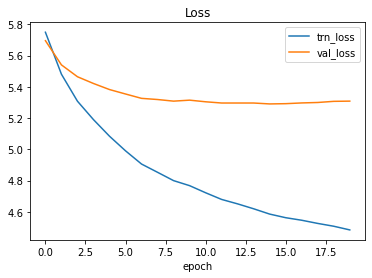

In [30]:
data.plot.line(x='epoch',y=['trn_loss','val_loss'], title='Loss');

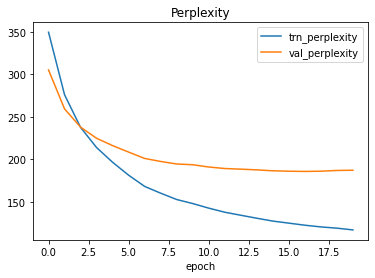

In [31]:
data.plot.line(x='epoch',y=['trn_perplexity','val_perplexity'], title='Perplexity');

We can see that even though the training loss and validation loss diverge, both lines keep decreasing over time, and seem that it may be starting to overfit if we keep training the model for more epochs.

# Pre-trained Word Embeddings
To use the pre-trained word embedding I needed to (1) train the skip-gram model, (2) create a new dataloader based on the new vocabulary. Then I instantiated the `SimpleRNN` class passing the embedding matrix as a parameter. Inside the class I used `nn.Embedding.from_pretrained` to load the embedding matrix, and set the `freeze` parameter to False in order to update the embedding while training. Finally, I trained the SimpleRNN model for 5 epochs using Adam optimizer with a learning rate of 0.01

## Create skip-gram model and embedding

In [17]:
def Skipgram(fname = "./wiki/trn-wiki.txt", ws=3, dim=32):
    model = train_unsupervised(fname, model='skipgram', ws=ws, dim=dim, neg=5)

    embeddings = np.array([model.get_word_vector(w) for w in model.words])
    
    vocab = dict()
    for i, v_word in enumerate(model.words):
        vocab[v_word] = i

    return embeddings, vocab

In [18]:
embeddings_sg, vocab_sg = Skipgram()

In [19]:
### Check if embedding 0 is being used
zero = np.zeros(32)
for i in range(embeddings_sg.shape[0]):
    comp = embeddings_sg[i] == zero
    if comp.all():
        print(True)

In [20]:
### Add <pad> to vocabulary
pad_idx = len(vocab_sg)
vocab_sg['<pad>'] = pad_idx
embeddings_sg = np.append(embeddings_sg,[[0]*32], axis=0)

In [21]:
print("The length of the new vocab is", len(vocab_sg))
print(f"The <pad> token id is: {pad_idx}")
print(f"The <unk> token id is: {vocab_sg['<unk>']}")
print(f"The <start> token id is: {vocab_sg['<start>']}")
print(f"The <stop> token id is: {vocab_sg['<stop>']}")

The length of the new vocab is 19640
The <pad> token id is: 19639
The <unk> token id is: 3
The <start> token id is: 9
The <stop> token id is: 10


## Create dataloader based on the pre-trained embeddings

In [22]:
def text_transform_input(s):
    output = []
    for token in s.split():
        if token != '<stop>':
            if token in vocab_sg:
                output.append(vocab_sg[token])
            else:
                output.append(vocab_sg['<unk>'])
    return output

def text_transform_target(s):
    output = []
    for token in s.split():
        if token != '<start>':
            if token in vocab_sg:
                output.append(vocab_sg[token])
            else:
                output.append(vocab_sg['<unk>'])
    return output

In [23]:
def collate_batch(batch):
    input_sentences_list = []
    target_sentences_list = []
    for sentence in batch:
        i_tensor = torch.tensor(text_transform_input(sentence))
        input_sentences_list.append(i_tensor)
        t_tensor = torch.tensor(text_transform_target(sentence))
        target_sentences_list.append(t_tensor)
    
    return pad_sequence(input_sentences_list, padding_value=pad_idx), pad_sequence(target_sentences_list, padding_value=pad_idx)

trn_dataloader = DataLoader(dataset_trn, batch_sampler=BucketIterator(dataset_trn,8), collate_fn=collate_batch)
dev_dataloader = DataLoader(dataset_dev, batch_sampler=BucketIterator(dataset_dev,8), collate_fn=collate_batch)

In [24]:
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

model = SimpleRNN(
    vocab_size=len(vocab_sg),
    pretrained_embedding=torch.tensor(embeddings_sg, dtype=torch.float32),
    drop_rate=0.5,
    n_inputs=32,
    n_hidden_units=32,
    n_layers=1,
    pad_idx=pad_idx
).to(device)
optimizer = optim.Adam(
    params=model.parameters(),
    lr=0.01,
    weight_decay=0
)
criterion = nn.NLLLoss(ignore_index=pad_idx)
epochs = 5

for epoch in range(epochs):
    print('\n' if epoch != 0 else '')
    print(f"Epoch {epoch}\n")
    model = train(
        model=model,
        trn_dataloader=trn_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    trn_loss, avg_trn_log_prob = eval(
        data_iter=trn_dataloader,
        model=model,
        criterion=criterion,
        pad_idx=pad_idx,
        device=device
    )
    val_loss, avg_val_log_prob = eval(
        data_iter=dev_dataloader,
        model=model,
        criterion=criterion,
        pad_idx=pad_idx,
        device=device
    )
    trn_perplexity = math.exp(avg_trn_log_prob)
    val_perplexity = math.exp(avg_val_log_prob)
    print(f"\nTraining Loss: {trn_loss}")
    print(f"Perplexity Training set: {math.exp(trn_loss)}")
    print(f"Validation Loss: {val_loss}")
    print(f"Perplexity Validation set: {math.exp(val_loss)}")


Epoch 0

[500]:	trn_loss = 6.2870
[1000]:	trn_loss = 6.2680
[1500]:	trn_loss = 6.2128
[2000]:	trn_loss = 6.1900

Training Loss: 6.007727711836135
Perplexity Training set: 406.5584519299134
Validation Loss: 5.9447093526006265
Perplexity Validation set: 381.7283968068788


Epoch 1

[500]:	trn_loss = 5.9908
[1000]:	trn_loss = 6.0263
[1500]:	trn_loss = 5.9816
[2000]:	trn_loss = 6.0252

Training Loss: 5.79390888865825
Perplexity Training set: 328.2937834195342
Validation Loss: 5.84952349064154
Perplexity Validation set: 347.0689594623188


Epoch 2

[500]:	trn_loss = 5.9018
[1000]:	trn_loss = 5.9017
[1500]:	trn_loss = 5.8924
[2000]:	trn_loss = 5.9771

Training Loss: 5.6923142891538445
Perplexity Training set: 296.5791970424478
Validation Loss: 5.82473694813716
Perplexity Validation set: 338.5720593520178


Epoch 3

[500]:	trn_loss = 5.8316
[1000]:	trn_loss = 5.8798
[1500]:	trn_loss = 5.8538
[2000]:	trn_loss = 5.9463

Training Loss: 5.637140164777195
Perplexity Training set: 280.658931376231

- Perplexity on training data: `269.46`
- Perplexity on validation data: `336.88`

# Brown cluster

In [1]:
!cat ./trn-wiki-c100-p1.out/paths | grep thirty

1100000	thirty	95


In [3]:
output = !cat ./trn-wiki-c100-p1.out/map | grep 1100000

file = open('./cluster.txt', 'w')
for l in output:
    word = l.split('\t')[0]
    print(word)
    file.write(word+'\n')
file.close()

gaa
ditches
muscat
wax
ballistic
bernardo
banded
hewn
ammonia
ufo
abusive
gasoline
southbound
boogie
lucasfilm
fewest
mk
succeeding
westbound
chip
spherical
nineteen
seventy
seventeen
sixty
eighteen
successive
fourteen
thirteen
krak
sixteen
fifty
forty
fifteen
eleven
twelve
rio
thirty
consecutive
twenty
nine
ten
eight
seven
six
five
four
two
three


## 2. How do you think about the quality of this cluster? Any justification?
The Brown algorithm clusters words based on a probabilistic model, therefore we can not expect it to work perfectly. From the words inside the same cluster as `thirty`, we can see that there are words like `twelve` and `twenty` that are related with the word `thirty` because they are numbers. However there are other words like `bernardo` or `abusive` that are not related with numbers. One possible explanation for this would be that in the `wiki-txt` corpus that we applied the Brown algorithm, all of the words listed above are probably in the same sentences or contexts, and since the algorithm is probabilistic, it grouped them together.